In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd


from wordcloud import WordCloud
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
from sklearn.preprocessing import LabelEncoder

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, LSTM, Embedding, Bidirectional,Dropout

import re 
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

In [6]:
test_data = pd.read_csv("test.txt", header=None, sep=";", names=["Comment","Emotion"], encoding="utf-8")
train_data = pd.read_csv("train.txt", header=None, sep=";", names=["Comment","Emotion"], encoding="utf-8")
validation_data = pd.read_csv("val.txt", header=None, sep=";", names=["Comment","Emotion"], encoding="utf-8")
print("Train : ", train_data.shape)
print("Test : ", test_data.shape)
print("Validation : ", validation_data.shape)

Train :  (16000, 2)
Test :  (2000, 2)
Validation :  (2000, 2)


In [7]:
train_data.head()

,Comment,Emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


In [8]:
train_data['length'] = [len(x) for x in train_data['Comment']]
train_data.head()

,Comment,Emotion,length
0,i didnt feel humiliated,sadness,23
1,i can go from feeling so hopeless to so damned...,sadness,108
2,im grabbing a minute to post i feel greedy wrong,anger,48
3,i am ever feeling nostalgic about the fireplac...,love,92
4,i am feeling grouchy,anger,20


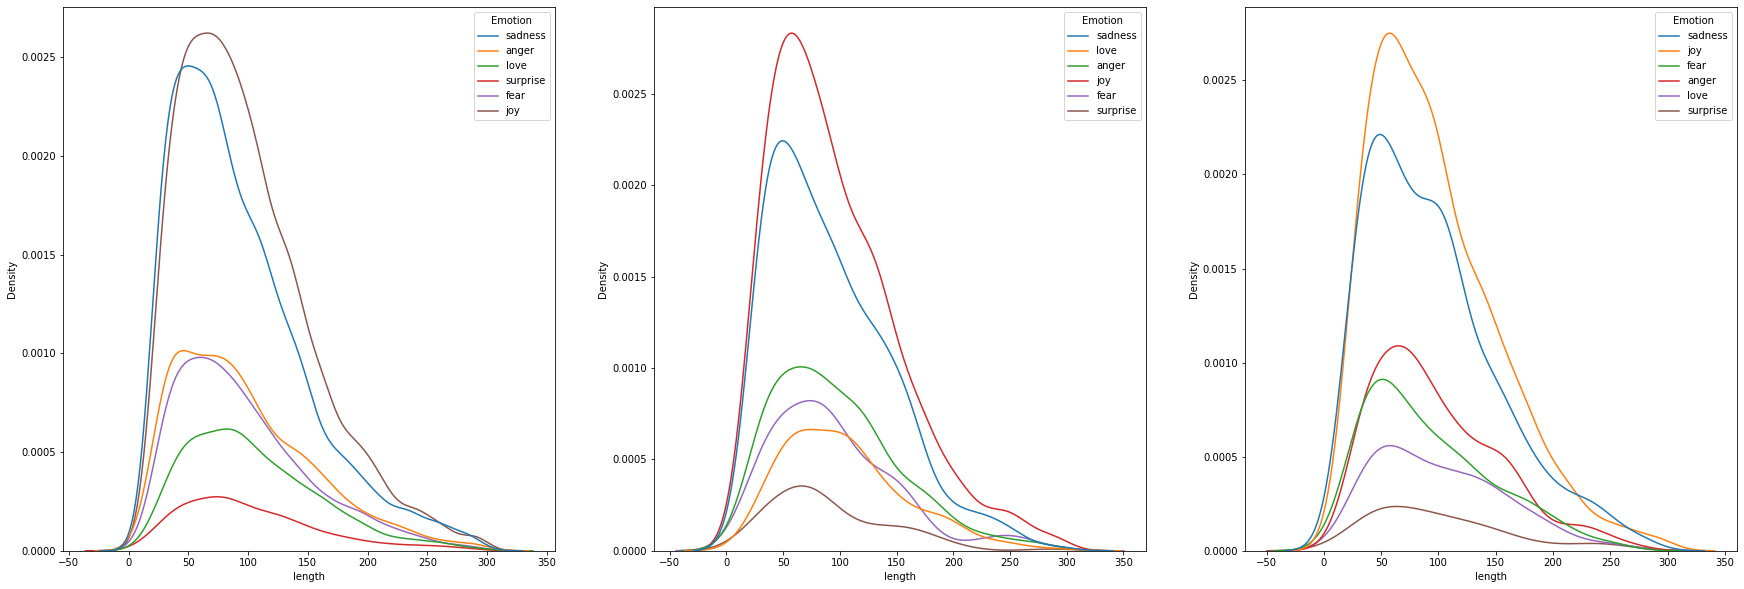

In [9]:
all_data = {'Train Data': train_data, 'Validation Data': validation_data, 'Test Data': test_data}
fig, ax = plt.subplots(1,3, figsize=(30,10))
for i, df in enumerate(all_data.values()):
    df2 = df.copy()
    df2['length'] = [len(x) for x in df2['Comment']]
    sns.kdeplot(data=df2,x='length',hue='Emotion', ax=ax[i])
plt.show()

In [10]:
def words_cloud(wordcloud, df):
    plt.figure(figsize=(10, 10))
    plt.title(df+' Word Cloud', size = 16)
    plt.imshow(wordcloud) 
    # No axis details
    plt.axis("off");

In [11]:
emotions_list = train_data['Emotion'].unique()
emotions_list

array(['sadness', 'anger', 'love', 'surprise', 'fear', 'joy'],
      dtype=object)

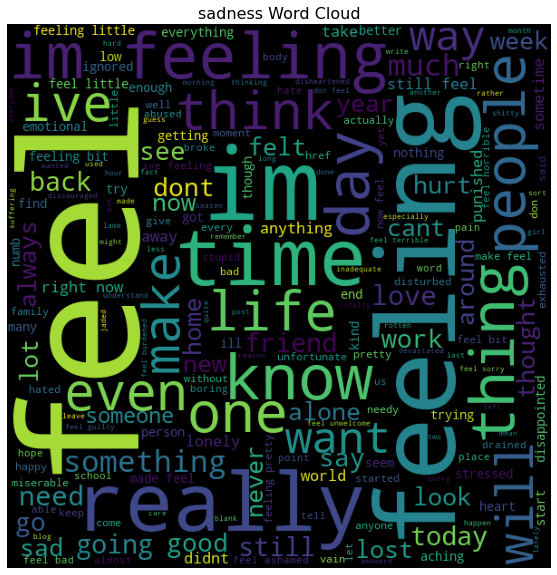

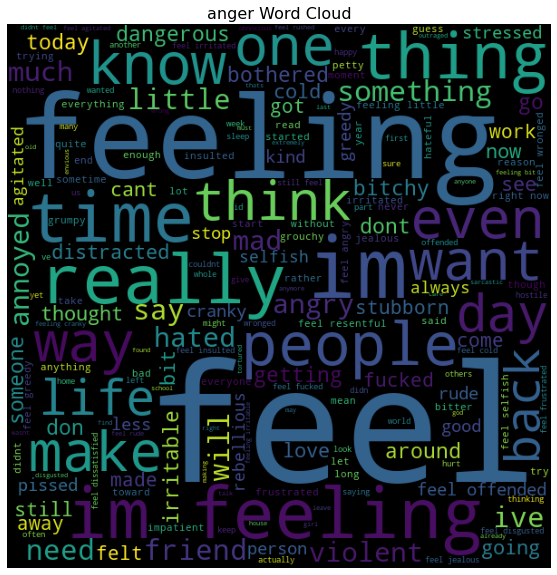

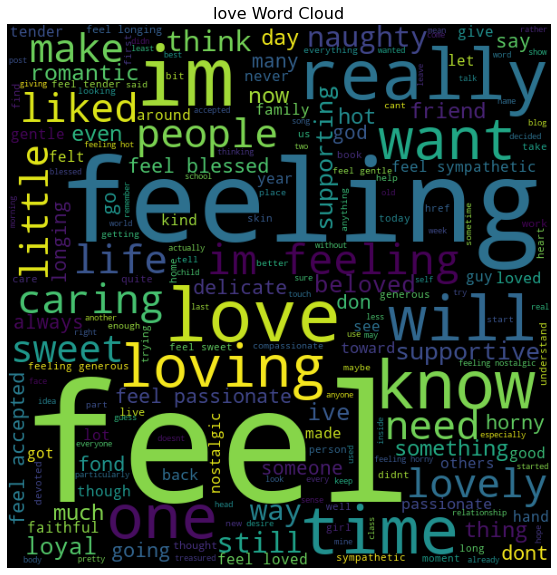

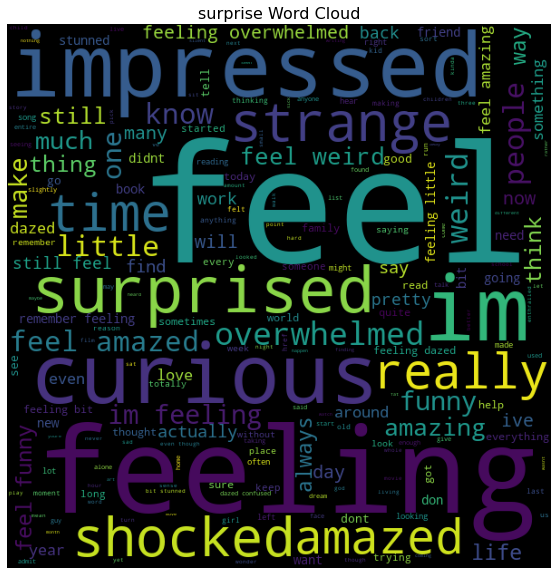

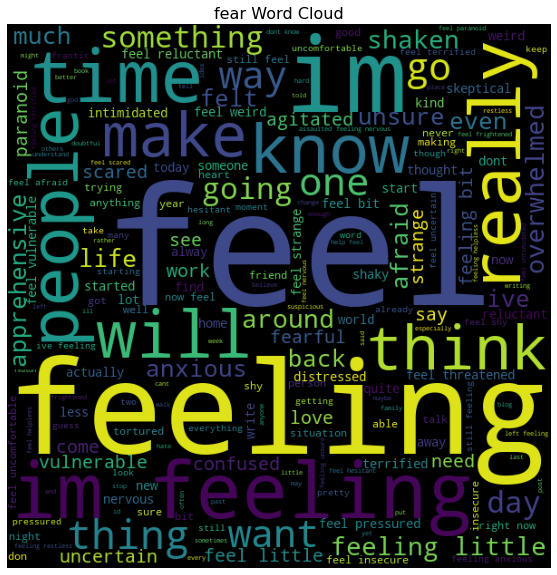

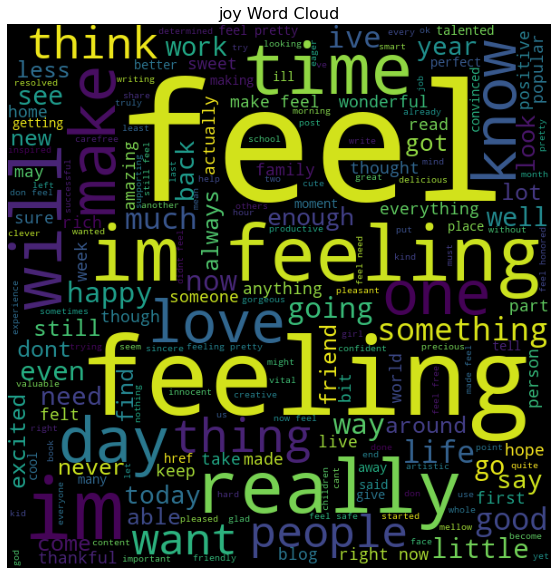

In [12]:
for emotion in emotions_list:
    text = ' '.join([sentence for sentence in train_data.loc[train_data['Emotion'] == emotion,'Comment']])
    wordcloud = WordCloud(width = 600, height = 600).generate(text)
    words_cloud(wordcloud, emotion)

In [13]:
lb = LabelEncoder()
train_data['Emotion'] = lb.fit_transform(train_data['Emotion'])
test_data['Emotion'] = lb.fit_transform(test_data['Emotion'])
validation_data['Emotion'] = lb.fit_transform(validation_data['Emotion'])

In [14]:
train_data.head(10)

,Comment,Emotion,length
0,i didnt feel humiliated,4,23
1,i can go from feeling so hopeless to so damned...,4,108
2,im grabbing a minute to post i feel greedy wrong,0,48
3,i am ever feeling nostalgic about the fireplac...,3,92
4,i am feeling grouchy,0,20
5,ive been feeling a little burdened lately wasn...,4,65
6,ive been taking or milligrams or times recomme...,5,122
7,i feel as confused about life as a teenager or...,1,73
8,i have been with petronas for years i feel tha...,2,98
9,i feel romantic too,3,19


# Clean stopwords

In [18]:
nltk.download('stopwords')
stopwords = set(nltk.corpus.stopwords.words('english'))
max_len=train_data['length'].max()
max_len
# tokenizer = Tokenizer()
# tokenizer.fit_on_texts(pd.concat(X_train, axis=0))
vocabSize = 11000
from tensorflow.keras.preprocessing.text import one_hot
def text_cleaning(df, column):
    """Removing unrelevent chars, Stemming and padding"""
    stemmer = PorterStemmer()
    corpus = []
    
    for text in df[column]:
        text = re.sub("[^a-zA-Z]", " ", text)
        text = text.lower()
        text = text.split()
        text = [stemmer.stem(word) for word in text if word not in stopwords]
        text = " ".join(text)
        corpus.append(text)
    one_hot_word = [one_hot(input_text=word, n=vocabSize) for word in corpus]
    pad = pad_sequences(sequences=one_hot_word,maxlen=max_len,padding='pre')
    print(pad.shape)
    return pad
x_train = text_cleaning(train_data, "Comment")
x_test = text_cleaning(test_data, "Comment")
x_val = text_cleaning(validation_data, "Comment")
y_train = train_data["Emotion"]
y_test = test_data["Emotion"]
y_val = validation_data["Emotion"]
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_val = to_categorical(y_val)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
(16000, 300)
(2000, 300)
(2000, 300)


model

In [19]:
model = Sequential()
model.add(Embedding(input_dim=vocabSize,output_dim=150,input_length=300))
model.add(Dropout(0.2))
model.add(LSTM(128))
model.add(Dropout(0.2))
model.add(Dense(64,activation='sigmoid'))
model.add(Dropout(0.2))
model.add(Dense(6,activation='softmax'))

In [20]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 150)          1650000   
                                                                 
 dropout (Dropout)           (None, 300, 150)          0         
                                                                 
 lstm (LSTM)                 (None, 128)               142848    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 6)                 3

In [21]:
callback = EarlyStopping(monitor="val_loss", patience=2, restore_best_weights=True)

In [22]:
hist = model.fit(x_train,y_train,epochs=10,batch_size=64,
                 validation_data=(x_val,y_val), verbose=1, callbacks=[callback])

Epoch 1/10
250/250 [==============================] - 200s 790ms/step - loss: 1.5413 - accuracy: 0.3792 - val_loss: 1.0885 - val_accuracy: 0.6370
Epoch 2/10
250/250 [==============================] - 195s 778ms/step - loss: 0.6752 - accuracy: 0.7732 - val_loss: 0.4496 - val_accuracy: 0.8340
Epoch 3/10
250/250 [==============================] - 193s 771ms/step - loss: 0.3263 - accuracy: 0.8904 - val_loss: 0.3259 - val_accuracy: 0.8855
Epoch 4/10
250/250 [==============================] - 193s 771ms/step - loss: 0.2142 - accuracy: 0.9280 - val_loss: 0.3184 - val_accuracy: 0.8800
Epoch 5/10
250/250 [==============================] - 195s 780ms/step - loss: 0.1652 - accuracy: 0.9431 - val_loss: 0.3347 - val_accuracy: 0.8805
Epoch 6/10
250/250 [==============================] - 195s 782ms/step - loss: 0.1324 - accuracy: 0.9551 - val_loss: 0.3959 - val_accuracy: 0.8775


In [23]:
model.evaluate(x_val,y_val,verbose=1)

63/63 [==============================] - 6s 91ms/step - loss: 0.3184 - accuracy: 0.8800


[0.31839272379875183, 0.8799999952316284]

In [24]:
model.evaluate(x_test,y_test,verbose=1)

63/63 [==============================] - 6s 100ms/step - loss: 0.3546 - accuracy: 0.8755


[0.354632169008255, 0.8755000233650208]

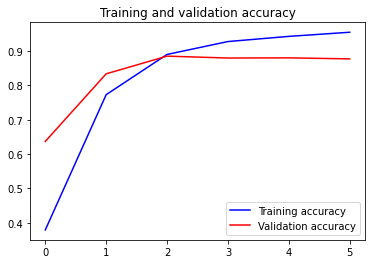

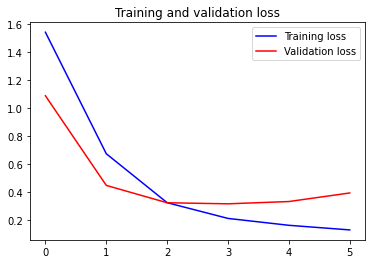

In [25]:
accuracy = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
loss=hist.history['loss']
val_loss=hist.history['val_loss']
epochs=range(len(accuracy))

plt.plot(epochs,accuracy,'b', label='Training accuracy')
plt.plot(epochs,val_acc,'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs,loss,'b', label='Training loss')
plt.plot(epochs,val_loss,'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [26]:
def sentence_cleaning(sentence):
    """Pre-processing sentence for prediction"""
    stemmer = PorterStemmer()
    corpus = []
    text = re.sub("[^a-zA-Z]", " ", sentence)
    text = text.lower()
    text = text.split()
    text = [stemmer.stem(word) for word in text if word not in stopwords]
    text = " ".join(text)
    corpus.append(text)
    one_hot_word = [one_hot(input_text=word, n=vocabSize) for word in corpus]
    pad = pad_sequences(sequences=one_hot_word,maxlen=max_len,padding='pre')
    return pad

In [35]:
sentences = [
            "He was speechles when he found out he was accepted to this new job",
            "This is outrageous, how can you talk like that?",
            "I feel like im all alone in this world",
            "He is really sweet and caring",
             "I feel tired",
             "The movie was very scary I cant sleep"  
            ]
for sentence in sentences:
    print(sentence)
    sentence = sentence_cleaning(sentence)
    result = lb.inverse_transform(np.argmax(model.predict(sentence), axis=-1))[0]
    proba =  np.max(model.predict(sentence))
    print(f"{result} : {proba}\n\n")

He was speechles when he found out he was accepted to this new job
joy : 0.8491486310958862


This is outrageous, how can you talk like that?
anger : 0.8296880722045898


I feel like im all alone in this world
sadness : 0.8816798329353333


He is really sweet and caring
love : 0.6730502247810364


I feel tired
sadness : 0.7196136713027954


The movie was very scary I cant sleep
anger : 0.37877747416496277


